# Generalized Weighted Max-cut Solver

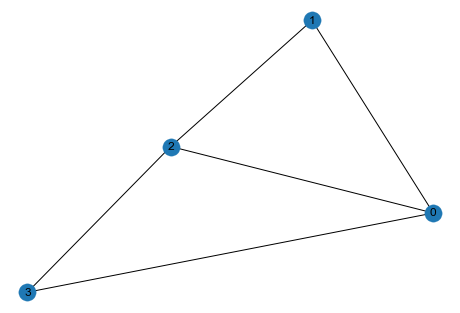

In [132]:
import networkx as nx
from matplotlib import pyplot as plt

"""INPUTS -- ENTER NUMBER OF NODES AND EDGE SPECIFICATIONS HERE"""
nodes = range(4)
E     =[(0,1,0.5),(1,2,2),(2,0,1.5), (2,3,1.5), (0,3,0.5)] # Each edge in array is formatted as (start_node, end_node, weight)

### Visualize graph
G = nx.Graph() 
G.add_nodes_from(nodes)
G.add_weighted_edges_from(E)

pos          = nx.spring_layout(G)
default_axis = plt.axes(frameon=False)

nx.draw_networkx(G, ax=default_axis)

In [133]:
import cirq
import numpy as np
import math
from matplotlib import pyplot as plt
import random
from scipy.optimize import minimize

# Defines the list of qubits
num = len(nodes)
depth = 4
shots = 1000
qubits = [cirq.GridQubit(0, i) for i in range(0, num)]

# Initializes all qubits into uniform superposition
def initialization(qubits):
    for i in qubits:
        yield cirq.H.on(i)

In [134]:
# Defines the cost unitary
def cost_unitary(qubits, gamma):
    for i in E:
        start_node = i[0]    #start node of edge
        end_node = i[1]      #end node of edge
        w = i[2]             #weight of edge
        # Encoding time evolution operator (exponentiated cost Hamiltonian) onto circuit
        yield cirq.ZZPowGate(exponent=-1*w*gamma/math.pi).on(qubits[start_node], qubits[end_node])

# Defines the mixer unitary
def mixer_unitary(qubits, alpha):
    for i in range(0, len(qubits)):
        # Increasing the probability of measurement for states marked by cost unitary 
        yield cirq.XPowGate(exponent=-1*alpha/math.pi).on(qubits[i])

In [135]:
# Executes the circuit
def create_circuit(params):
    gamma = [params[0], params[2], params[4], params[6]] # parameters for each cost layer
    alpha = [params[1], params[3], params[5], params[7]] # parameters for each mixer layer

    circuit = cirq.Circuit()
    circuit.append(initialization(qubits)) # Initializing all qubits by applying a Hadamard transform
    
    """For each layer, append a cost layer and a mixer layer to the circuit consecutively with the matching parameters"""
    for i in range(0, depth):
        circuit.append(cost_unitary(qubits, gamma[i]))
        circuit.append(mixer_unitary(qubits, alpha[i]))
    
    circuit.append(cirq.measure(*qubits, key='x')) # Measure the circuit

    """Conducts several shots of the circuit to inspect probability distribution and output bitstrings that were measured"""
    simulator = cirq.Simulator()
    results = simulator.run(circuit, repetitions=shots)
    results = str(results)[2:].split(", ")
    new_res = []
    for i in range(0, shots):
        hold = []
        for j in range(0, num):
            hold.append(int(results[j][i]))
        new_res.append(hold)
    return new_res

In [136]:
# Defines the cost function
def cost_function(params):
    res = create_circuit(params)
    total_cost = 0
    """Iterate over each result"""
    for i in range(0, len(res)):
        """Iterate over each edge in each result"""
        for j in E:
            start_node = j[0]
            end_node = j[1]
            w = j[2]
            """Calculate the cost of each edge and add it to the total cost"""
            total_cost = total_cost + -1*(w*res[i][start_node]*(1-res[i][end_node]) + w*res[i][end_node]*(1-res[i][start_node]))
    
    total_cost = float(total_cost)/shots
    print("Cost: "+str(total_cost))

    return total_cost

Cost: -2.994
Cost: -3.366
Cost: -3.4385
Cost: -3.6745
Cost: -3.2955
Cost: -3.2115
Cost: -3.4745
Cost: -3.468
Cost: -3.288
Cost: -3.5795
Cost: -4.091
Cost: -3.1345
Cost: -4.285
Cost: -4.1985
Cost: -4.253
Cost: -3.508
Cost: -4.297
Cost: -4.069
Cost: -4.2295
Cost: -3.53
Cost: -4.261
Cost: -3.9105
Cost: -3.989
Cost: -4.3255
Cost: -4.218
Cost: -4.2825
Cost: -4.288
Cost: -4.203
Cost: -4.3025
Cost: -4.275
Cost: -4.314
Cost: -4.32
Cost: -4.3445
Cost: -4.294
Cost: -4.337
Cost: -4.2825
Cost: -4.275
Cost: -4.32
Cost: -4.3205
Cost: -4.3495
Cost: -4.293
Cost: -4.2905
Cost: -4.2535
Cost: -4.321
Cost: -4.2815
Cost: -4.318
Cost: -4.3015
Cost: -4.3155
Cost: -4.332
Cost: -4.3015
Cost: -4.2645
Cost: -4.273
Cost: -4.296
Cost: -4.28
Cost: -4.2725
Cost: -4.3045
Cost: -4.3
Cost: -4.3
Cost: -4.291
Cost: -4.285
Cost: -4.3075
Cost: -4.298
Cost: -4.296
Cost: -4.339
Cost: -4.3275
Cost: -4.309
Cost: -4.2765
Cost: -4.288
Cost: -4.279
Cost: -4.315
Cost: -4.2475
Cost: -4.2895
Cost: -4.3035
Cost: -4.3165
Cost: -4.303


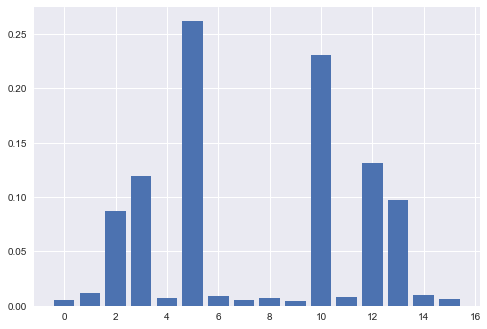

In [137]:
# Defines the optimization method

init =[float(random.randint(-314, 314))/float(100) for i in range(0, 8)]
out = minimize(cost_function, x0=init, method="COBYLA", options={'maxiter':100})

optimal_params = out['x']
f = create_circuit(optimal_params)

# Creates visualization of the optimal state
nums = []
freq = []

for i in range(0, len(f)):
    number = 0
    for j in range(0, len(f[i])):
        number += 2**(len(f[i])-j-1)*f[i][j]
    if (number in nums):
        freq[nums.index(number)] = freq[nums.index(number)] + 1
    else:
        nums.append(number)
        freq.append(1)

freq = [s/sum(freq) for s in freq]

# print(nums)
print(freq)
x = range(0, 2**num)
y = []
for i in range(0, len(x)):
    if (i in nums):
        y.append(freq[nums.index(i)])
    else:
        y.append(0)
plt.style.use("seaborn")
plt.bar(x, y)
plt.show()